# Import Related Libraries

In [1]:
import pandas as pd
import string
import spacy
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Data Preprocessing

In [2]:
#read dataset
data = pd.read_csv('Dataset.csv')
#pre-view of dataset
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017/12/31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017/12/29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017/12/31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017/12/30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017/12/29,1


# Data Preprocess

In [3]:
#count the variable without data
data.isnull().sum()

title      52
text       56
subject    56
date       70
label       0
dtype: int64

In [4]:
#remove null values
data = data.dropna()

#remove duplicate values
data = data.drop_duplicates()

In [5]:
# #randomly chosse 100 data for test, comment out during official runtime
# data = data.sample(n=1000, random_state=42)

In [6]:
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017/12/31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017/12/29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017/12/31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017/12/30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017/12/29,1


In [7]:
#remove punctuations from text, title, and subject
for col in ['text', 'title', 'subject']:
    data[col] = data[col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [8]:
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
def load_variavle(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

In [9]:
stop_words = load_variavle('stop_words.txt')

In [10]:
#load stop words from nlkt
#if report download fail from nltk, use the file offered above
stop_words = set(stopwords.words('english'))

#remove stop words
for col in ['text', 'title', 'subject']:
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [11]:
#separate words in text, title, and subject
for col in ['text', 'title', 'subject']:
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split()]))

In [12]:
#words stem extraction for text, title, and subject
stemmer = PorterStemmer()
for col in ['text', 'title', 'subject']:
    data[col] = data[col].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

In [13]:
#concatenate 'text', 'title', and 'subject' columns together
data['combined'] = data['title'] + ' ' + data['subject'] + ' ' + data['text']

In [14]:
# calculate the average length of true and fake news
fake_mean_len = data[data['label'] == 0]['combined'].apply(lambda x: len(x)).mean()
real_mean_len = data[data['label'] == 1]['combined'].apply(lambda x: len(x)).mean()

print("average length of fake news：", fake_mean_len)
print("average length of true news：", real_mean_len)

average length of fake news： 1683.8501534265258
average length of true news： 1627.9312149356465


In [15]:
data = data.reset_index(drop=True)

#speatre feature column and label column
X = data['combined']
y = data['label']

In [16]:
#initialize
vectorizer = TfidfVectorizer(stop_words='english')
#vetorize
X = vectorizer.fit_transform(X)

In [17]:
#split train set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes Part

In [18]:
#construct naive bayes model
nb_model = MultinomialNB()

#set hyperparameters set
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

#start grid search
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

#out optimal hyperparameter and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 0.1}
Best Score:  0.9511191941801904


In [19]:
#construct naive bayes model
nb_model = MultinomialNB(alpha=0.1)

#fit model
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
#evaluate model on testing set
accuracy = nb_model.score(X_test, y_test)
print('Accuracy: ', accuracy * 100)

Accuracy:  95.38891997761611


In [20]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(cm)

#precision
precision = precision_score(y_test, y_pred)
print("precision: ", precision)

#recall
recall = recall_score(y_test, y_pred)
print("recall: ", recall)

#F-measure
f1 = f1_score(y_test, y_pred)
print("F-measure: ", f1)

[[4418  240]
 [ 172 4105]]
precision:  0.9447640966628308
recall:  0.9597848959551087
F-measure:  0.9522152632799814


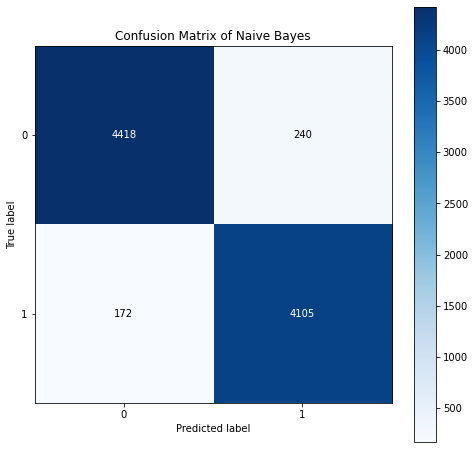

In [21]:
#draw confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='Blues')

#add labels
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.xticks(rotation=0)
plt.title("Confusion Matrix of Naive Bayes")

#add numbers
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

#add color bar
plt.colorbar(im)
plt.grid(False)
plt.savefig('confusion_matrix_nb.png',dpi=800)
plt.show()

In [22]:
#out report of naive bayes
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      4658
           1       0.94      0.96      0.95      4277

    accuracy                           0.95      8935
   macro avg       0.95      0.95      0.95      8935
weighted avg       0.95      0.95      0.95      8935



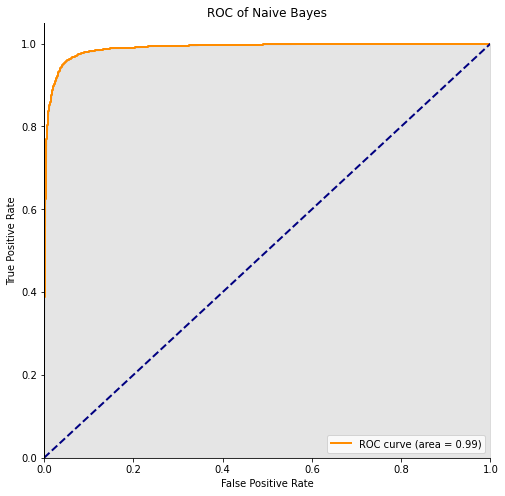

AUC: 0.9892445969750631


In [23]:
# Get prediction probabilities
y_score = nb_model.predict_proba(X_test)[:, 1]

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.fill_between(fpr, tpr, color='gray', alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Naive Bayes')
plt.legend(loc="lower right")

# Add axes
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)

# Set background and contours
plt.gca().set_facecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save the plot
plt.savefig('ROC_nb.png', dpi=800)

# Show the plot
plt.show()

# Output AUC
print("AUC:", roc_auc)


# Random Forest Part

In [24]:
#Scramble training set
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

#Choose first 1000 samples to process tuning
X_train_subset = X_train_shuffled[:1000]
y_train_subset = y_train_shuffled[:1000]

#construct random forest model
rf = RandomForestClassifier(random_state = 42)

#define hyperparameters set
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

#start grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_subset, y_train_subset)

#out optimal hyperparameter and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best Score:  0.9810000000000001


In [25]:
#construct random forest model
rf_model = RandomForestClassifier(random_state = 42,max_depth = None, min_samples_split = 2, n_estimators = 300)
#fit model
rf_model.fit(X_train,y_train)
#test on testing set
y_pred = rf_model.predict(X_test)
#evaluate model on testing set
accuracy = rf_model.score(X_test, y_test)
print('Accuracy: ', accuracy * 100)

Accuracy:  99.29490766648014


In [26]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(cm)

#precision
precision = precision_score(y_test, y_pred)
print("precision: ", precision)

#recall
recall = recall_score(y_test, y_pred)
print("recall: ", recall)

#F-measure
f1 = f1_score(y_test, y_pred)
print("F-measure: ", f1)

[[4626   32]
 [  31 4246]]
precision:  0.9925198690977092
recall:  0.9927519289221417
F-measure:  0.9926358854471069


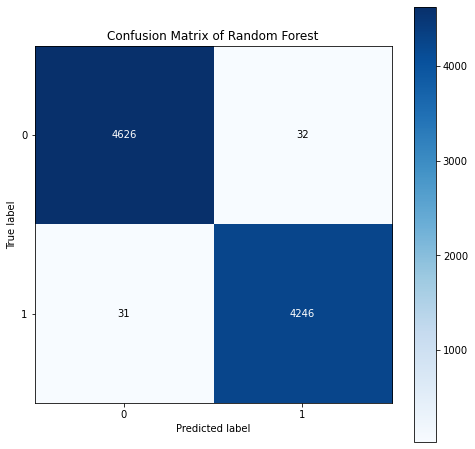

In [27]:
#draw confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='Blues')

#add labels
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.xticks(rotation=0)
plt.title("Confusion Matrix of Random Forest")

#add numbers
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

#add color bar
plt.colorbar(im)
plt.grid(False)
plt.savefig('confusion_matrix_rf.png',dpi=800)
plt.show()

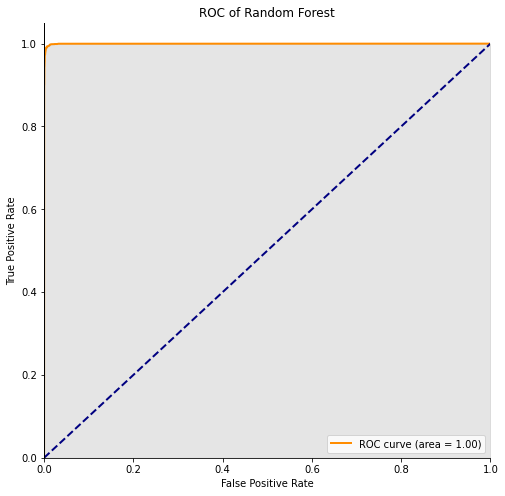

AUC: 0.9997415705623045


In [28]:
# Get prediction probabilities
y_score = rf_model.predict_proba(X_test)[:, 1]

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.fill_between(fpr, tpr, color='gray', alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest')
plt.legend(loc="lower right")

# Add axes
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)

# Set background and contours
plt.gca().set_facecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save the plot
plt.savefig('ROC_rf.png', dpi=800)

# Show the plot
plt.show()

# Output AUC
print("AUC:", roc_auc)

In [29]:
#out report of random forest
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4658
           1       0.99      0.99      0.99      4277

    accuracy                           0.99      8935
   macro avg       0.99      0.99      0.99      8935
weighted avg       0.99      0.99      0.99      8935

